# <span style="color:blue">Survival Analysis on startups </span>

<b>Authors</b> : Bertrand Gallice & Ben Chen

<b>Motivations</b> : After seeing in the course many examples of dataset about living/dying humans, we thought it would be interesting to conduct a survival analysis on entities that are not alive. The question we ask here is : How long can we expect to remain CEO of a startup, before it is either acquired or closed. We use funding data as explanatory variable for the analysis.

<b>Data used</b> : We use a snapshot of crunchbase made in 2013. Crunchbase is a database of the startups environment in the US. The database is filled by the users of the platform. This dataset is right censored on a very large time scale, so we will apply transformations to study startups on a smaller time window.
The data can be found at : https://github.com/datahoarder/crunchbase-october-2013

## <span style="color:red">I. Data exploration/wrangling</span>

Enter the folder path of the data :

In [241]:
path = "C:/Users/GALLICE/Documents/Perso/Etudes/DSTI/Cours/Survival Analysis/project/Data/crunchbase-october-2013-master/"
path

[1] "C:/Users/GALLICE/Documents/Perso/Etudes/DSTI/Cours/Survival Analysis/project/Data/crunchbase-october-2013-master/"

In [242]:
#-------------import of companies.csv---------------#

datafile = "crunchbase-companies.csv"
startups <- read.csv(paste(path,datafile, sep= ""), 
                     sep = ',',
                     stringsAsFactors = FALSE)

startups$funding_total_usd <- as.integer(startups$funding_total_usd)

startups$category_code <- factor(x = startups$category_code, ordered = FALSE)
startups$status <- factor(startups$status, ordered = FALSE)
startups$country_code <- factor(startups$country_code, ordered = FALSE)
startups$state_code <- factor(startups$state_code, ordered = FALSE)
startups$region <- factor(startups$region, ordered = FALSE)
startups$city <- factor(startups$city, ordered=FALSE)

startups$founded_at <- as.Date(startups$founded_at, "%Y-%m-%d")
startups$first_funding_at <- as.Date(as.character(startups$first_funding_at, format="%Y-%m-%d"))
startups$last_funding_at <- as.Date(as.character(startups$last_funding_at, format="%Y-%m-%d"))
startups$last_milestone_at <- as.Date(as.character(startups$last_milestone_at, format="%Y-%m-%d"))


names(startups)[2] <- "company_name"

summary(startups)

Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion to integer range"

  permalink         company_name           category_code  funding_total_usd  
 Length:17727       Length:17727       software   :2688   Min.   :2.910e+02  
 Class :character   Class :character   biotech    :2060   1st Qu.:7.835e+05  
 Mode  :character   Mode  :character   web        :1662   Median :3.721e+06  
                                       mobile     :1135   Mean   :1.625e+07  
                                       enterprise :1125   3rd Qu.:1.450e+07  
                                       advertising: 739   Max.   :1.654e+09  
                                       (Other)    :8318   NA's   :1523       
       status      country_code   state_code             region    
 acquired : 1673   USA:17727    CA     :6658   SF Bay       :4819  
 closed   :  553                NY     :1837   New York     :1741  
 ipo      :  344                MA     :1425   Boston       :1367  
 operating:15157                TX     : 836   Los Angeles  :1126  
                                WA  

Note that USA is the only country represented in this dataset.

The next chunk of code computes the lifetime vector of startups. We use the <i>foundation_date</i> variable as the start date, and the <i>last_milestone_at</i> variable to close the interval. Depending on the state of the startup (operating, closed, acquired, IPO), the time will be considered to be censored or not. Operating startup are censored observations.

In [243]:
start_date <- startups$founded_at

startups$last_milestone_at[is.na(startups$last_milestone_at)] <- startups$last_funding_at[is.na(startups$last_milestone_at)]#imputes missing dates in last_milestone_at

end_date <- startups$last_milestone_at

if(FALSE){
end_date <- startups$last_funding_at #or end_date <- startups$last_milestone_at ?
                                     #for startups that are acquired, the last_milestone could be better
                                     # startups[which(startups$status=="acquired"), c("last_funding_at","last_milestone_at")]
}

days_of_existence <- data.frame(matrix(data = NA,nrow = dim(startups)[1], ncol = 1))

for(i in seq(1,dim(startups)[1])){
  days_of_existence[i,] <- as.integer(end_date[i]-start_date[i])
  if(!is.na(days_of_existence[i,])){
    if(days_of_existence[i,] <= 30){
      days_of_existence[i,] <- NA
    }
  }
}

#create column for lifetime of the startup
names(days_of_existence) <- "days_of_existence"
startups <- cbind(startups,days_of_existence)
startups <- startups[!is.na(days_of_existence),]
startups <- startups[!is.na(startups$funding_total_usd),]

### <span style="color:red">I.1. Plotting the data</span>

 days_of_existence
 Min.   :   31    
 1st Qu.:  643    
 Median : 1393    
 Mean   : 2027    
 3rd Qu.: 2646    
 Max.   :39092    
 NA's   :5560     

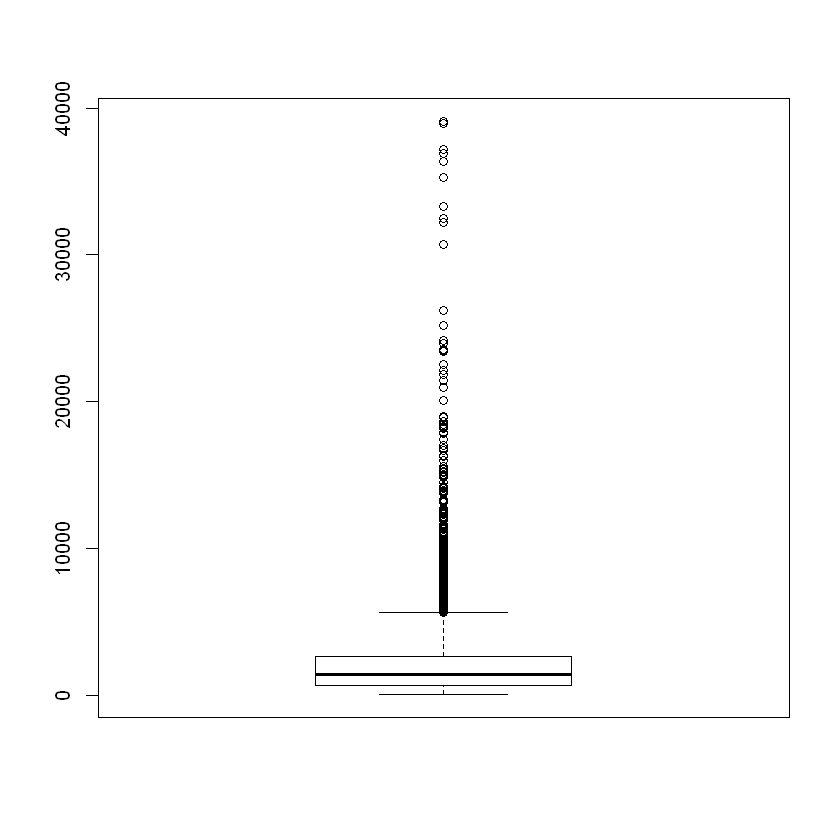

In [244]:
#overview of the lifetime  of the startups in the dataset
summary(days_of_existence)
boxplot(days_of_existence)
rm(days_of_existence)

We see in the boxplot that there are a lot of outliers with a lifetime over 6000 years (16 years of existence). This shows that many datapoints that have been added in the dataset are not related to young startups, but rather old companies. For the survival analysis, we will choose a start date accordingly so we don't take old companies into account.

We will now visualize the distribution of the startups states.

Warning message:
"Removed 90 rows containing non-finite values (stat_bin)."

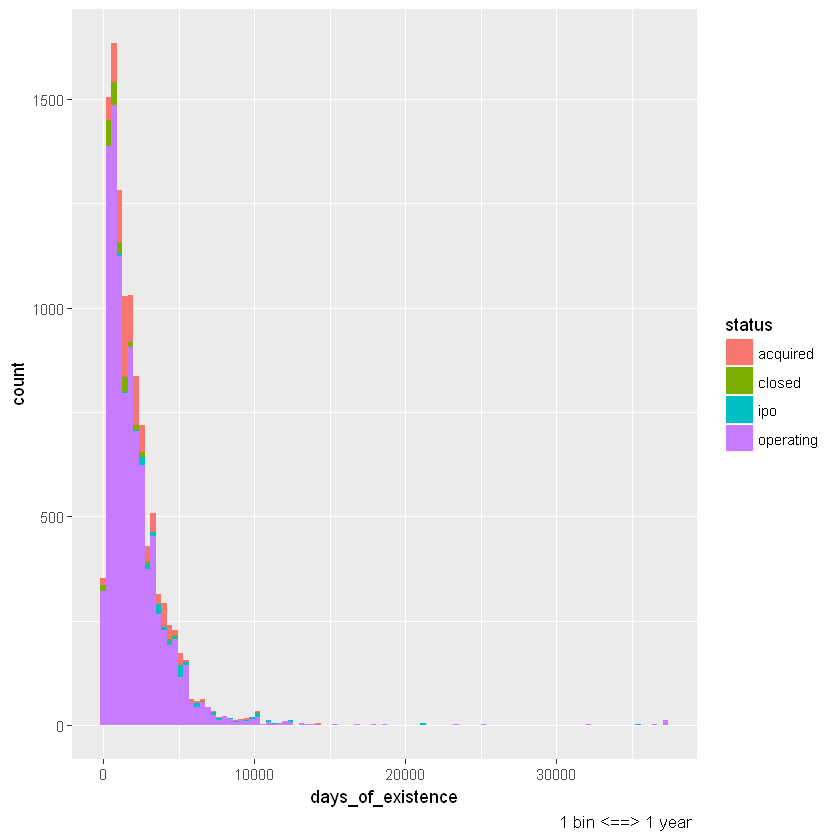

In [245]:
library(ggplot2)

graph_area_subset <- startups[c("days_of_existence", "status", "funding_total_usd", "category_code")]
graph_area_subset <- graph_area_subset[graph_area_subset$days_of_existence,]

ggplot(data=graph_area_subset,aes(x=days_of_existence, group=status, fill=status)) + geom_histogram(binwidth=365) + labs(caption = "1 bin <==> 1 year ")  

As said just before, we notice that there are many outliers, because very ancient companies are in the dataset. For a better visualization of the histogram, we display in the next graph companies with a lifetime smaller or equal to 40 years.

Also, the very high number of operating startups compared to the other state could be explained by the lack of update on the database. Since it relies on the users of the database, many startups can have been added to the database and not updated enough after.

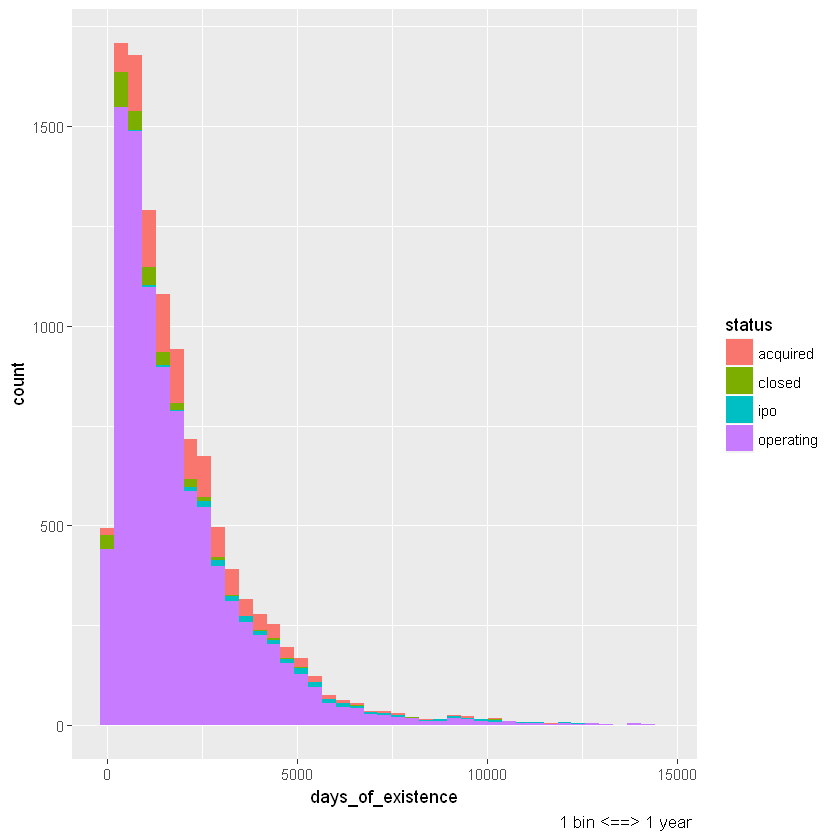

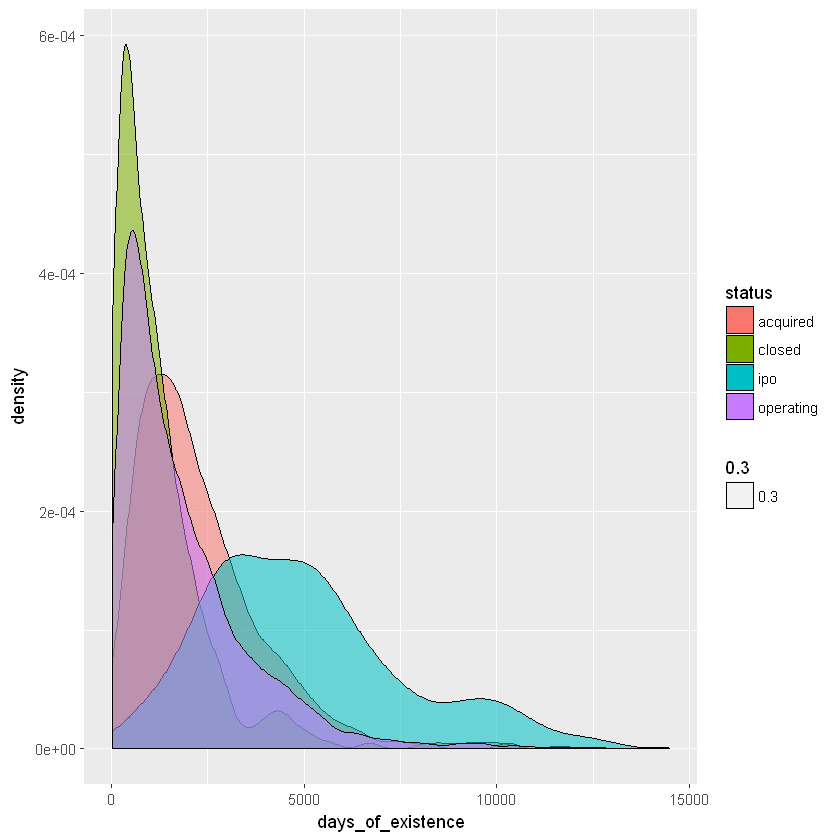

In [246]:
graph_area_subset <- startups[c("days_of_existence", "status", "funding_total_usd", "category_code")]
graph_area_subset <- graph_area_subset[graph_area_subset$days_of_existence<14600,]

ggplot(data=graph_area_subset,aes(x=days_of_existence, group=status, fill=status)) + geom_histogram(binwidth=365) + labs(caption = "1 bin <==> 1 year ")  
ggplot(data=graph_area_subset,aes(x=days_of_existence, group=status, fill=status, alpha=0.3)) + geom_density()

<b>- From the histogram: </b>
    We see that there are much more startups operating than in other states in the dataset. For the survival analysis, operating is considered as alive, and acquired or closed or both will be considered as dead. 
   
<b>- From the density plot:</b>
    We see that if a startup closes it will be very early in its life. We also see that the startups are being acquired at the same time that the quantity of startups being closed decreases.

In [247]:
table(startups$status)


 acquired    closed       ipo operating 
     1230       321       218      9562 

Since the number of closed (=dead) startups is very small compared to the number of operating (=alive) startups, we will try 3 different survival models. One model with the closed status as "deceased state", another model with closed+acquired, and a last one with only acquired.

The following plot are related to the total funding received by each startup, according to their status.

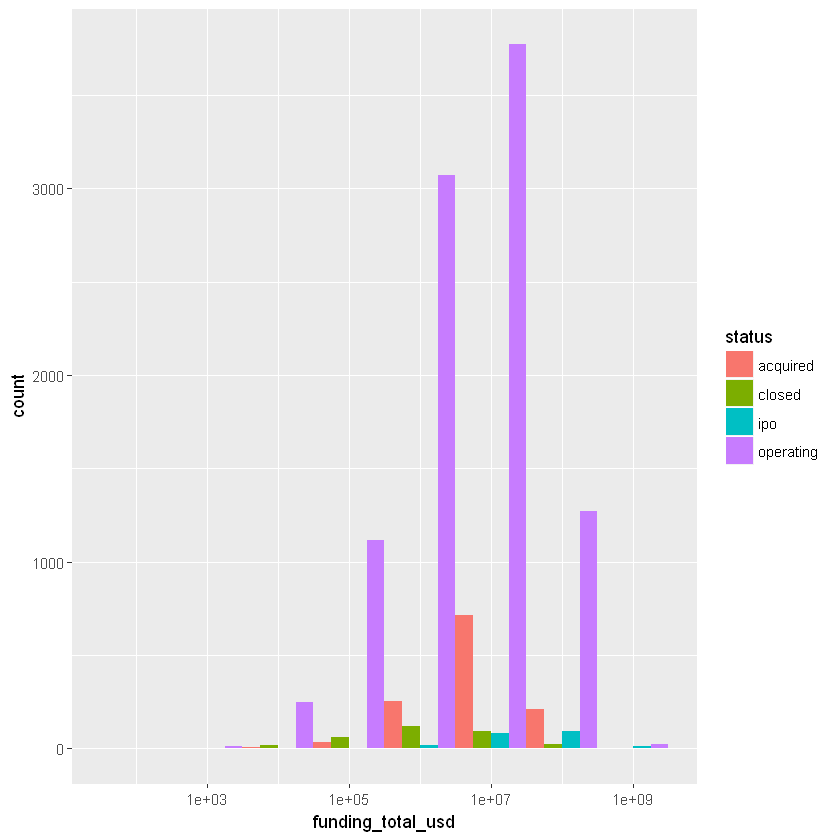

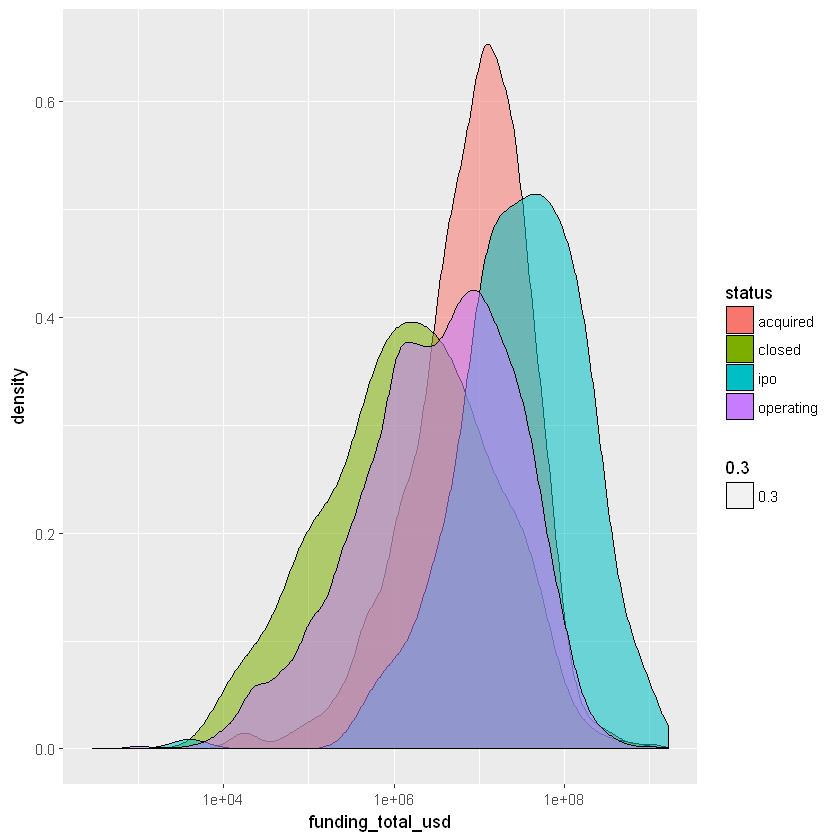

In [248]:
ggplot(data=graph_area_subset,aes(x=funding_total_usd, group=status, fill=status)) + geom_histogram(position='dodge', binwidth=1) + scale_x_log10()
ggplot(data=graph_area_subset,aes(x=funding_total_usd, group=status, fill=status, alpha=0.3)) + geom_density() + scale_x_log10()
rm(graph_area_subset)

The density plot shows a hierarchy in the statuses related to the money received. Closed received on average less money than acquired who received on average less money than IPO. 

What can be interesting is that operating startups fundings follow a distribution that looks like a mix of the other statuses. This similarity may lead to problems when fitting the survival model.

### <span style="color:red">I.2. Filtering the dataset with a starting time point, and a limit for right censoring</span>

In [249]:
#------------Create target column from the status column-----------#

target <- data.frame(matrix(data = NA,nrow = dim(startups)[1], ncol = 1))
names(target) <- "target"

for (i in seq(1, dim(startups)[1])){
  startup_status <- startups$status[i]
  if (startup_status == 'acquired'){
    target[i,1] <- 1
  }
  else if (startup_status == 'ipo'){
    target[i,1] <- 0
  }
  else if (startup_status == 'operating'){
    target[i,1] <- 0
  }
  else if (startup_status == "closed"){
    target[i,1] <- 1
  }
}

startups <- cbind(startups,target)
rm(target)

#___________target column created______________#


This target column considers acquired & closed as the deceased status. We use both statuses here to make the plotting more clear, and we'll use this later to create a Surv object with the combination of acquired and closed as the target value.

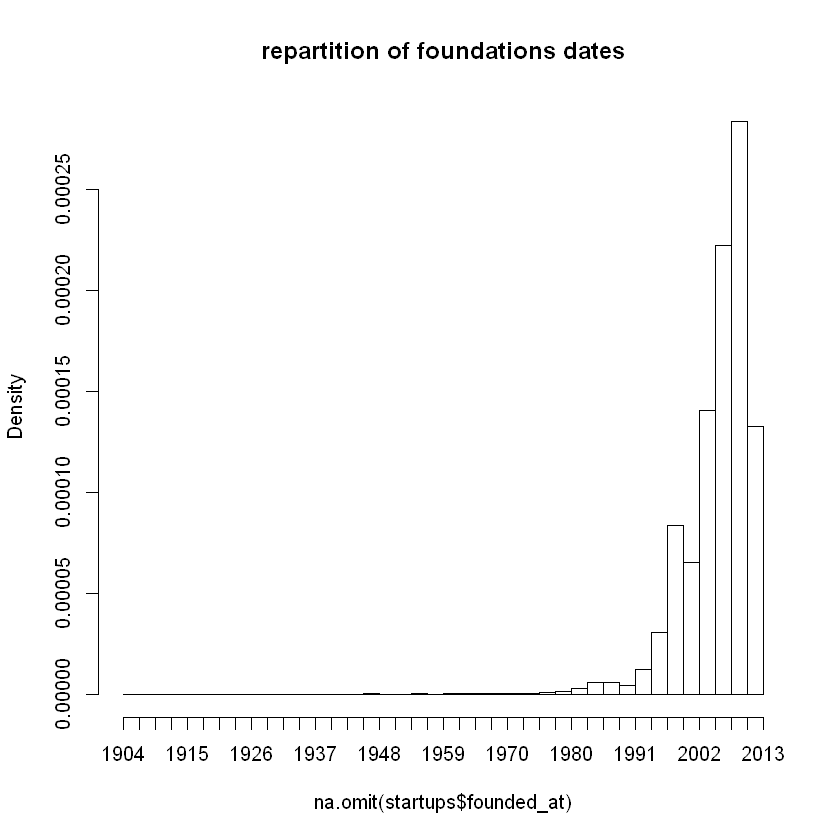

In [250]:
hist(na.omit(startups$founded_at), breaks = 30, main="repartition of foundations dates")

Some outliers before 1990 are visible

#### <span style="color:green">You can change the lower limit for foundation date here :</span>

In [251]:
lower_date_limit <- "2002-01-01"
lower_date_limit #%Y-%m-%d

[1] "2002-01-01"

We then proceed to remove the startups founded prior to this date

In [252]:
#----------removes the values prior to the lower_date_limit--------------#
rows_to_remove <- startups$founded_at < lower_date_limit
rows_to_remove[is.na(rows_to_remove)] <- TRUE

startups <- startups[!rows_to_remove,]


#TODO : impute missing values in funding_total_usd from raised_amount_usd


#______________removes the values prior to the lower_date_limit_____________#

#### <span style="color:green">You can change the upper limit for the censoring date here, in years :</span>

In [253]:
censoring_years = 10
censoring_years

[1] 10

### <span style="color:red">I.3. Exploring the target repartition among categories</span>

In [254]:
startups <- startups[(startups$founded_at > lower_date_limit & startups$days_of_existence <= censoring_years*365),]

The following plot shows the repartition of events among the different categories of startups.
First 5 categories (in terms of counts) are : 
    
    - Software
    - Biotech
    - Web
    - Enterprise
    - Mobile

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

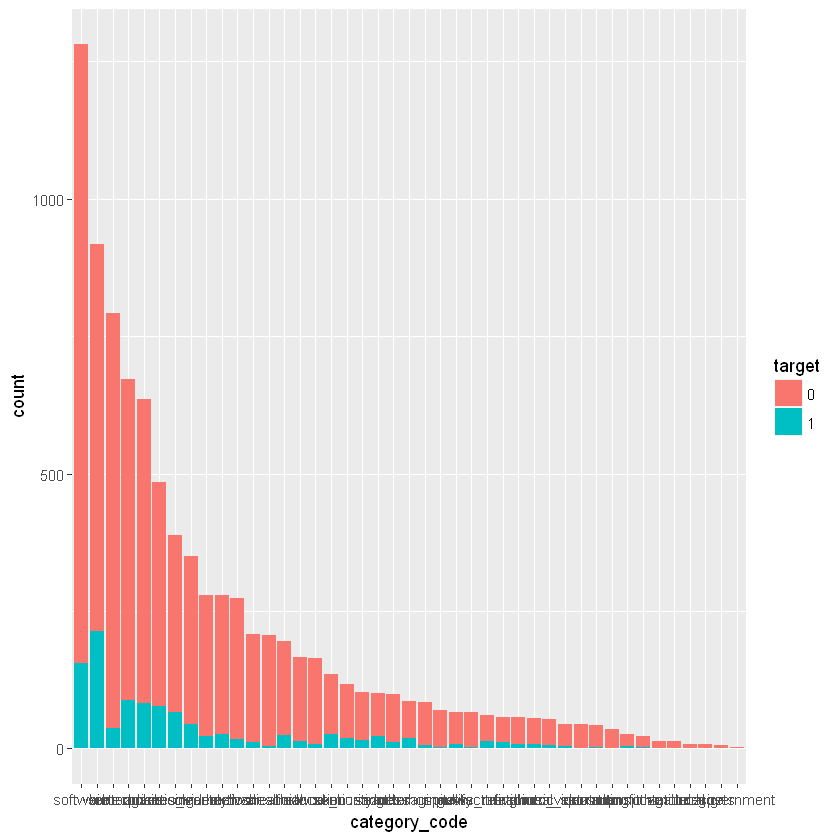

In [255]:
graph_area_subset <- startups[,c("days_of_existence", "target","category_code")]
categories <- graph_area_subset$category_code
t_categories <- data.frame(table(categories))
t_categories <- t_categories[order(t_categories$Freq, decreasing=T),]
graph_area_subset$category_code <- factor(graph_area_subset$category_code, levels=t_categories$categories, ordered=T)

#taking opportunity to order the factor vector of startups:
startups$category_code <- factor(startups$category_code, levels = t_categories$categories, ordered=T)

graph_area_subset$target <- factor(graph_area_subset$target)

ggplot(data=graph_area_subset,aes(x=category_code, group=target, fill=target)) + geom_histogram(stat="count") 

rm(categories)
rm(t_categories)
rm(graph_area_subset)

In [256]:
category_counts <- data.frame(table(startups$category_code))

survival_rate <- matrix(data=NA, ncol = 3, nrow = 42)
survival_rate <- data.frame(survival_rate)
names(survival_rate) <- c("category", "survival_rate", "observations")

for (i in 1:42){
    variable <- sum(startups$target[startups$category_code == levels(startups$category_code)[i]])
    variable <- variable/category_counts[i,2]
    variable <- 1 - variable
    survival_rate[i,1] <- levels(startups$category_code)[i]
    survival_rate[i,2] <- variable
    survival_rate[i,3] <- category_counts[i,2]
}

survival_rate[order(survival_rate$observations, decreasing=T),]

category,survival_rate,observations
software,0.8790952,1282
web,0.7666303,917
biotech,0.9532828,792
enterprise,0.8675595,672
mobile,0.8694969,636
advertising,0.8391753,485
games_video,0.8303342,389
ecommerce,0.8746439,351
cleantech,0.9178571,280
analytics,0.9068100,279


In the first categories in terms of number of observations, biotech startups have the best survival rate, and web startups have the worst. 

### <span style="color:red">I.4. Handling the fundings dataset</span>

We load a second dataset, <i>rounds of funding</i>. It provides additionnal information on the different fundings raised by each startup.

In [257]:
library(dplyr)

datafile = "crunchbase-rounds.csv"

rounds <- read.csv(paste(path,datafile, sep= ""), 
                     sep = ',',
                     stringsAsFactors = FALSE)

#sort rounds dataset by startup name
rounds$company_name <- factor(rounds$company_name)
rounds <- rounds[order(rounds$company_name),]
rounds$company_name <- sapply(rounds$company_name, as.character)

rounds$funding_round_type <- factor(rounds$funding_round_type)

rounds$funded_at <- as.Date(rounds$funded_at, "%Y-%m-%d")

str(rounds)

'data.frame':	31679 obs. of  13 variables:
 $ company_permalink    : chr  "/company/n-plusn" "/company/waywire" "/company/club-domains" "/company/pay-mobile-checkout-for-email-and-the-web" ...
 $ company_name         : chr  "#NAME?" "#waywire" ".Club Domains" "@Pay - Two-Click Checkout" ...
 $ company_category_code: chr  "software" "news" "software" "mobile" ...
 $ company_country_code : chr  "USA" "USA" "USA" "USA" ...
 $ company_state_code   : chr  "NY" "NY" "FL" "NM" ...
 $ company_region       : chr  "New York" "New York" "Fort Lauderdale" "Albuquerque" ...
 $ company_city         : chr  "New York" "New York" "Oakland Park" "Albuquerque" ...
 $ funding_round_type   : Factor w/ 9 levels "angel","crowdfunding",..: 1 6 7 6 6 9 7 3 1 9 ...
 $ funded_at            : Date, format: "2012-08-29" "2012-06-30" ...
 $ funded_month         : chr  "2012-08" "2012-06" "2013-05" "2012-07" ...
 $ funded_quarter       : chr  "2012-Q3" "2012-Q2" "2013-Q2" "2012-Q3" ...
 $ funded_year          : int 

And we explore rounds.csv :

In [258]:
table_df <- data.frame(table(rounds$company_name))

sum(table_df$Freq > 1)/length(table_df$Freq)

[1] 0.4174895

41% of observations are associated to more than 1 company. This will require some pre-processing on the data before merging it to the original dataset.

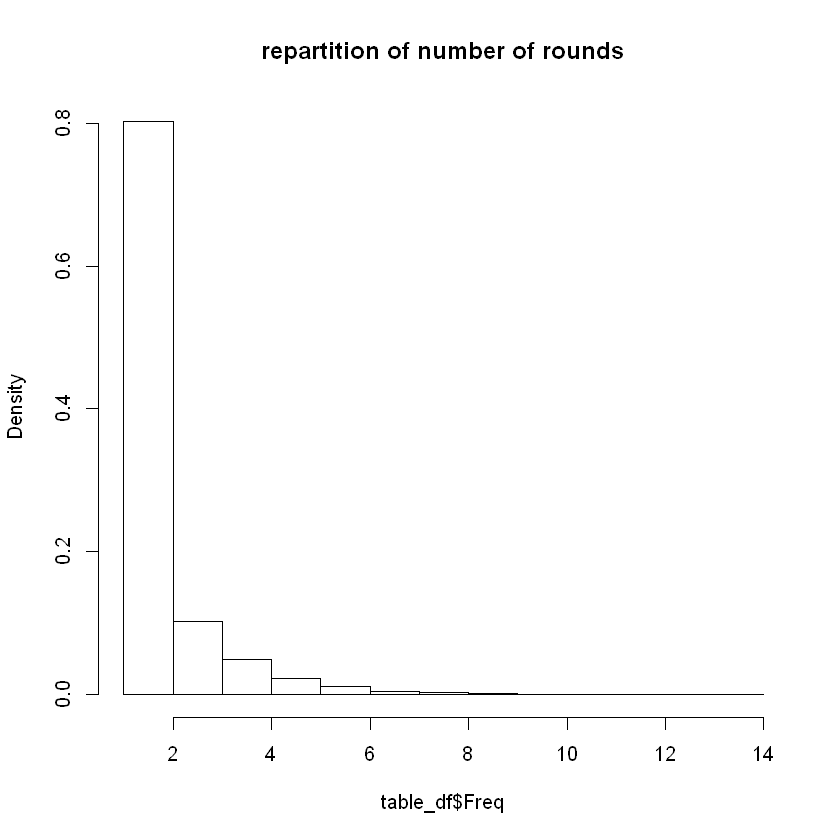

In [259]:
hist(table_df$Freq, freq = F, main="repartition of number of rounds")
rm(table_df)

## <span style="color:red">II. Survival analysis</span>

We want to study the impact of the following variables on the survival model :

 - total_funding_usd
 - funding_round_type
 - raised_amount_usd  (Money invested in 1 round)
 
We need to complete each line of the first dataset (companies, named startup in the code) with the corresponding fundings types, the funded amount associated, and their count.
 

We're studying startups that have been founded after this date : 

In [260]:
lower_date_limit

[1] "2002-01-01"

And we're using the following limit for censoring (in years) :

In [261]:
censoring_years
censoring_date <- censoring_years*365

[1] 10

In [262]:
library(survival)

#converting factor funding_rounds from rounds, to columns of count of this factor
funding_round_type_surv_shaped <- data.frame(matrix(data = 0, nrow=dim(startups)[1], ncol = 28))
col_names_fund_round_type <- levels(rounds$funding_round_type)
types_counts <- paste("count_",levels(rounds$funding_round_type), sep="")
time_fund <- paste("time_",levels(rounds$funding_round_type), sep="")
names(funding_round_type_surv_shaped) <- c("company_name",col_names_fund_round_type, types_counts, time_fund)

for (i in 1:dim(funding_round_type_surv_shaped)[1]){
  name <- startups$company_name[i]
  funding_round_type_surv_shaped[i,1] <- name
  
  company_details <- which(rounds$company_name == name)
  funding_rounds <- as.character(rounds$funding_round_type[company_details])#get all funding rounds type for startup i 
  if (length(funding_rounds) > 0){
    for (j in 1:length(funding_rounds)){
      if (is.numeric(rounds$raised_amount_usd[company_details][j])){
        
        #adds the amount invested
        funding_round_type_surv_shaped[i,funding_rounds[j]] <- rounds$raised_amount_usd[company_details][j]
        + funding_round_type_surv_shaped[i,funding_rounds[j]]
        
      }
      else{
        
        funding_round_type_surv_shaped[i,funding_rounds[j]] <- NA
      
        }
      
      #adds count to correponding type
      funding_round_type_surv_shaped[i,paste("count_", funding_rounds[j], sep ="")] <- 1 + funding_round_type_surv_shaped[i,paste("count_", funding_rounds[j], sep ="")]
      
      funded_after_x_days <- rounds$funded_at[company_details][j] - startups$founded_at[i]
      if (funding_round_type_surv_shaped[i,paste("time_", funding_rounds[j], sep ="")] == 0 ){
        funding_round_type_surv_shaped[i,paste("time_", funding_rounds[j], sep ="")] <- funded_after_x_days #Keeping the 1st fund date for the duplicates of one type of investment
      }
    }
  } 
}

Then, we merge the newly obtained funding_rounds data with a subset of companies data, and we remove rows containing NAs.

In [263]:
#shaping dataframe for survival analysis


censoring_filter <- function(x){
  if((x >censoring_date) || (x == 0)){
    return(TRUE)
  }
  else{
    return(FALSE)
  }
}
rows_to_remove <- sapply(startups$days_of_existence, censoring_filter )  #applying the censoring filter
rows_to_remove[is.na(rows_to_remove)] <- TRUE #also removing rows with NA lifetime

temp_startups <- startups[!rows_to_remove,]




surv_dataframe <- temp_startups[c("company_name","category_code", "funding_total_usd", "funding_rounds", "state_code")]

surv_dataframe$target_acquired <- c(rep(0,1,dim(surv_dataframe)[1]))
surv_dataframe$target_closed <- c(rep(0,1,dim(surv_dataframe)[1]))

for (i in 1:dim(surv_dataframe)[1]){
  if (temp_startups$status[i] == "acquired"){
    surv_dataframe$target_acquired[i] <- 1
  }
  if (temp_startups$status[i] == "closed"){
    surv_dataframe$target_closed[i] <- 1
  }
}

surv_target_all <- Surv(time = temp_startups$days_of_existence, event = temp_startups$target)
surv_target_acquired <- Surv(time = temp_startups$days_of_existence, event = surv_dataframe$target_acquired)
surv_target_closed <- Surv(time = temp_startups$days_of_existence, event = surv_dataframe$target_closed)

surv_dataframe <- left_join(surv_dataframe, funding_round_type_surv_shaped, by="company_name")
surv_dataframe <- data.frame(surv_dataframe,surv_target_all)
surv_dataframe <- data.frame(surv_dataframe,surv_target_acquired)
surv_dataframe <- data.frame(surv_dataframe,surv_target_closed)
surv_dataframe <- surv_dataframe[,-1]

str(surv_dataframe)

#TODO use function cut() to split numeric values into intervals


'data.frame':	8778 obs. of  36 variables:
 $ category_code       : Ord.factor w/ 43 levels "software"<"web"<..: 25 1 1 2 10 3 1 1 26 6 ...
 $ funding_total_usd   : int  1750000 600000 7000000 2535000 1250000 3000000 77500 719000 48950000 5500000 ...
 $ funding_rounds      : int  1 1 1 2 2 1 1 4 6 2 ...
 $ state_code          : Factor w/ 52 levels "","AK","AL","AR",..: 36 36 11 6 6 6 21 41 21 6 ...
 $ target_acquired     : num  0 0 0 1 1 0 0 0 0 0 ...
 $ target_closed       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ angel               : num  0 600000 0 15000 750000 0 0 500000 0 0 ...
 $ crowdfunding        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ other               : num  0 0 0 0 0 3000000 77500 150000 3000000 0 ...
 $ post.ipo            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ private.equity      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ series.a            : num  1750000 0 0 2520000 0 0 0 0 12400000 3000000 ...
 $ series.b            : num  0 0 7000000 0 0 0 0 0 2400000 2500000 ...
 $ series.c.           : num  

In [264]:
rm(temp_startups)
rm(funding_round_type_surv_shaped)

Putting money values in log scale :

In [265]:
surv_dataframe$funding_total_usd <- log(surv_dataframe$funding_total_usd+1, base=10)
surv_dataframe$angel <- log(surv_dataframe$angel + 1, base=10)
surv_dataframe$crowdfunding <- log(surv_dataframe$crowdfunding + 1, base=10)
surv_dataframe$other <- log(surv_dataframe$other + 1, base=10)
surv_dataframe$post.ipo <- log(surv_dataframe$post.ipo + 1, base=10)
surv_dataframe$private.equity <- log(surv_dataframe$private.equity + 1, base=10)
surv_dataframe$series.a <- log(surv_dataframe$series.a + 1, base=10)
surv_dataframe$series.b <- log(surv_dataframe$series.b + 1, base=10)
surv_dataframe$series.c. <- log(surv_dataframe$series.c. + 1, base=10)
surv_dataframe$venture <- log(surv_dataframe$venture + 1, base=10)

### <span style="color:red">II.1. Kaplan-Meier estimators for all categories</span>

In [266]:
#fitting model
fit.KMall <- survfit(surv_target_all ~ 1, data=surv_dataframe)
fit.KMacqui <- survfit(surv_target_acquired ~ 1, data=surv_dataframe)
fit.KMclos <- survfit(surv_target_closed ~ 1, data=surv_dataframe)

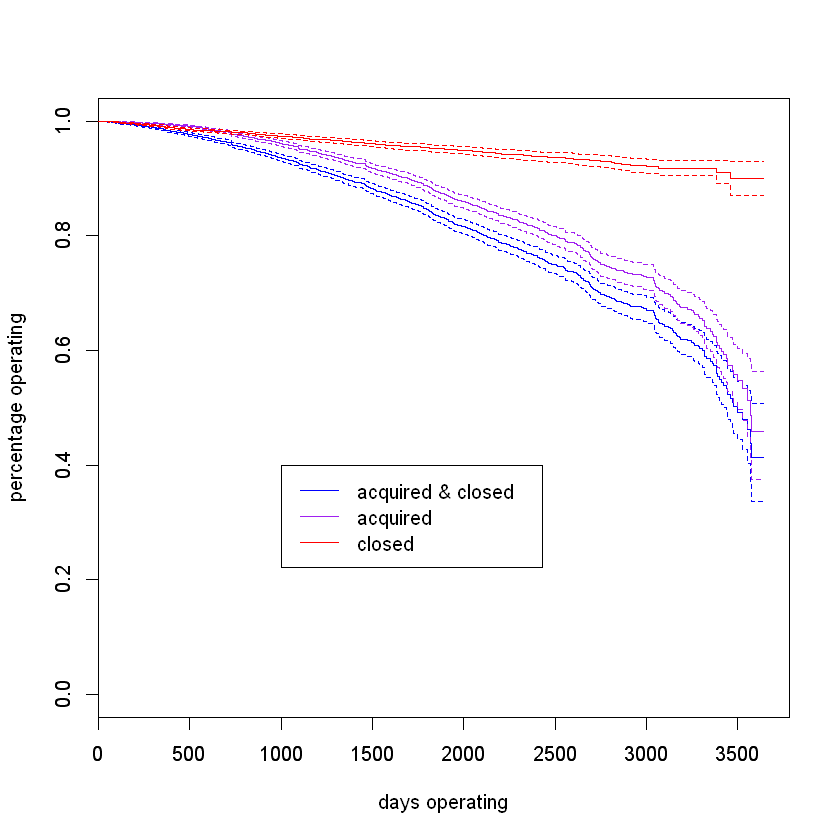

In [267]:
plot(fit.KMall,col="blue")
par(new=T)
plot(fit.KMacqui, col="purple")
par(new=T)
plot(fit.KMclos, xlab="days operating", ylab="percentage operating", col="red")
legend(1000,0.4, col =c("blue", "purple", "red"), legend=(c("acquired & closed", "acquired", "closed")), lty=1)

As expected, the acquired status is much more significant than the closed status. We will proceed as said before, trying to model the survival according to each status individually, or combined.

### <span style="color:red">II.2. Kaplan-Meier estimator on a subset of the categories</span>

We will now study the 1st four categories, in term of number of observations. We will then select the category with the most visible changes over time for the rest of the analysis.

In [268]:
temp_surv_dataframe_software <- surv_dataframe[surv_dataframe$category_code == "software",]
temp_surv_dataframe_biotech<- surv_dataframe[surv_dataframe$category_code == "biotech",]
temp_surv_dataframe_web <- surv_dataframe[surv_dataframe$category_code == "web",]
temp_surv_dataframe_mobile <- surv_dataframe[surv_dataframe$category_code == "mobile",]

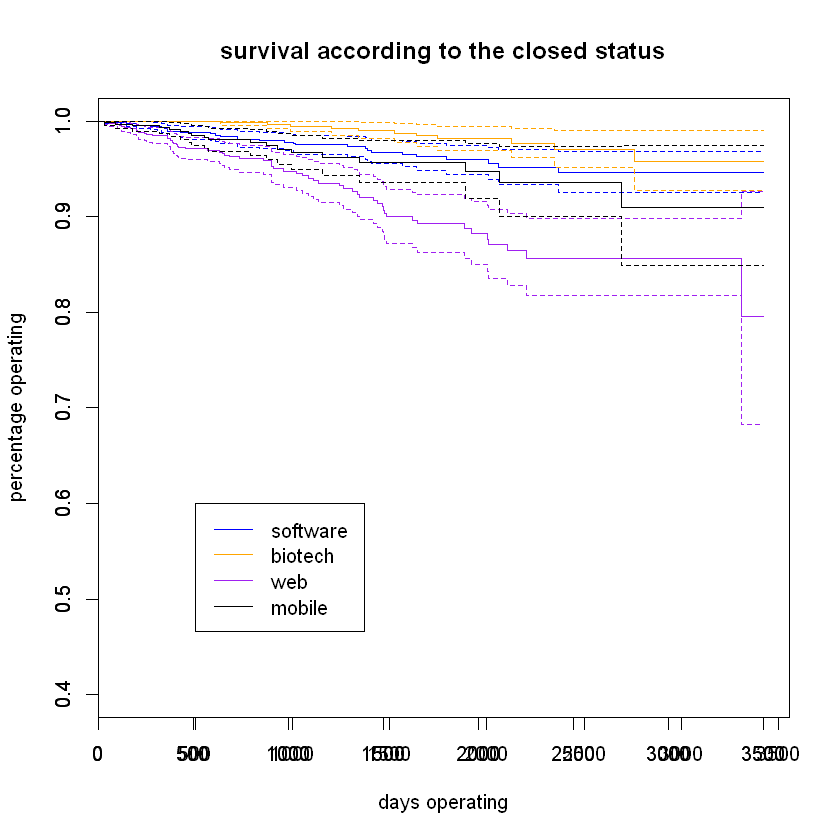

In [269]:


fit.KM <- survfit(surv_target_closed ~ 1, data=temp_surv_dataframe_software)
plot(fit.KM,col="blue", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_closed ~ 1, data=temp_surv_dataframe_biotech)
plot(fit.KM,col="orange", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_closed ~ 1, data=temp_surv_dataframe_web)
plot(fit.KM,col="purple", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_closed ~ 1, data=temp_surv_dataframe_mobile)
plot(fit.KM,col="black", xlab="days operating", ylab="percentage operating", xmax=3500, ylim=c(0.4,1), main = "survival according to the closed status")


legend(500,0.6, col =c("blue", "orange", "purple", "black"), legend=(c("software", "biotech","web", "mobile")), lty=1)

The biotech and the web are the most distant estimators from each other.

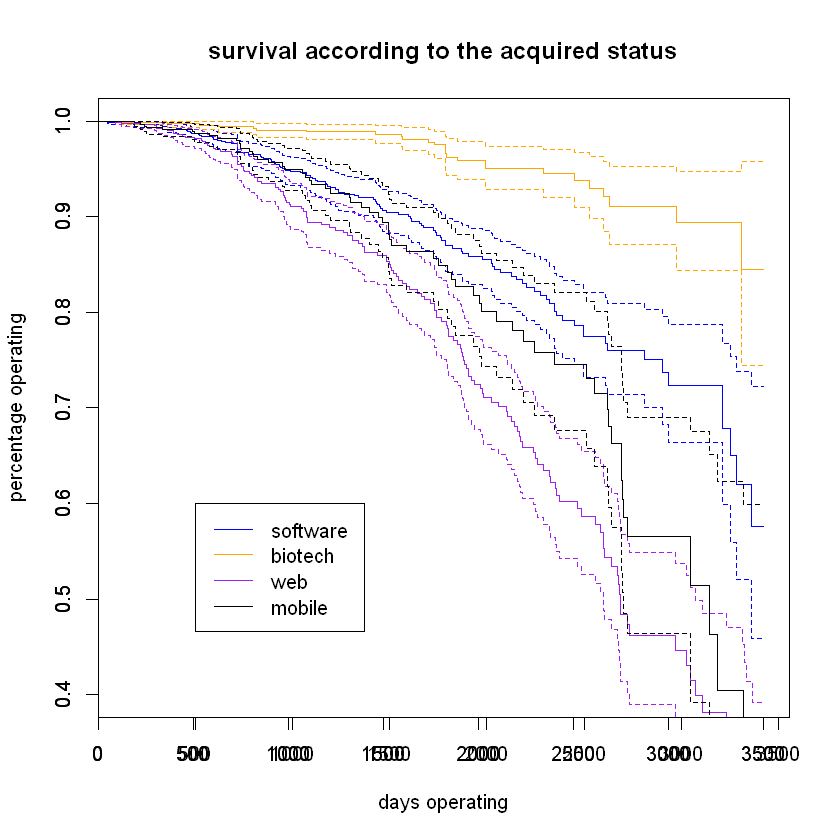

In [270]:
fit.KM <- survfit(surv_target_acquired ~ 1, data=temp_surv_dataframe_software)
plot(fit.KM,col="blue", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_acquired ~ 1, data=temp_surv_dataframe_biotech)
plot(fit.KM,col="orange", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_acquired ~ 1, data=temp_surv_dataframe_web)
plot(fit.KM,col="purple", xmax=3500, ylim=c(0.4,1))
par(new=T)
fit.KM <- survfit(surv_target_acquired ~ 1, data=temp_surv_dataframe_mobile)
plot(fit.KM,col="black", xlab="days operating", ylab="percentage operating", xmax=3500, ylim=c(0.4,1), main = "survival according to the acquired status")

legend(500,0.6, col =c("blue", "orange", "purple", "black"), legend=(c("software", "biotech","web", "mobile")), lty=1)

In both cases the Web category drops the fastest, and the biotech has the best survival. We will compare the differences between those two groups, to see what allows biotech companies to perform better. Also, the survival rate computed in  <span style="color:red"><b>I.3.</b></span> shows that biotech startups goes into IPO most frequently than other groups.


We will now make a logrank test between these two curves : 
    Logrank test :
    
        - H0:No difference between survival curves
        - H1: Statistical difference between the curves

In [271]:
subset_surv_dataframe <- surv_dataframe[surv_dataframe$category_code %in% c("biotech","web"),]

survdiff(formula = surv_target_acquired ~ category_code, data=subset_surv_dataframe)

Call:
survdiff(formula = surv_target_acquired ~ category_code, data = subset_surv_dataframe)

                        N Observed Expected (O-E)^2/E (O-E)^2/V
category_code=web     917      154       76      80.1       140
category_code=biotech 792       26      104      58.5       140

 Chisq= 140  on 1 degrees of freedom, p= 0 

The p-values equals 0, so we can reject H0. The curves are indeed different as we can see it on the plot above.

In [272]:
rm(temp_surv_dataframe_biotech)
rm(temp_surv_dataframe_mobile)
rm(temp_surv_dataframe_software)
rm(temp_surv_dataframe_web)

###  <span style="color:red">II.3. Survival according to the repartition of funding rounds</span>


How long after the founding date does the fundings starts ?

We split the fundings in 2 groups :

Group 1 : Main investments made in all startups 

    - series.a : 1st investment round
    - series.b : 2nd ----------------
    - series.c : 3rd ----------------
    
Group 2 : Side investments made out of the group 1 scope

    - angel : investment from a business angel
    - private.equity : comes from an investment fund, targeted towards old companies
    - venture : a kind of private equity, targeted towards startup in growth 
    - post.ipo : investment made after the startup went into stock market
    - other

In [273]:
library(grid)

web_surv_df <- surv_dataframe[surv_dataframe$category_code == 'web',]
aa = web_surv_df[c("angel","time_angel")]
aa = data.frame(aa, c("angel"))
names(aa) = c("amount", "time", "type")

bb = web_surv_df[c("crowdfunding", "time_crowdfunding")]
bb = data.frame(bb, c("crowdfunding"))
names(bb) = c("amount", "time", "type")

cc = web_surv_df[c("other", "time_other")]       
cc = data.frame(cc, c("other"))
names(cc) = c("amount", "time", "type")

dd = web_surv_df[c("post.ipo", "time_post.ipo" )] 
dd = data.frame(dd, c("post.ipo"))
names(dd) = c("amount", "time", "type")

ee = web_surv_df[c("private.equity", "time_private.equity")]
ee = data.frame(ee, c("private.equity"))
names(ee) = c("amount", "time", "type")

ff = web_surv_df[c("series.a", "time_series.a")] 
ff = data.frame(ff, c("series.a"))
names(ff) = c("amount", "time", "type")

gg = web_surv_df[c("series.b", "time_series.b")]  
gg = data.frame(gg, c("series.b"))
names(gg) = c("amount", "time", "type")

hh = web_surv_df[c("series.c.", "time_series.c.")]      
hh = data.frame(hh, c("series.c."))
names(hh) = c("amount", "time", "type")

ii = web_surv_df[c("venture", "time_venture")]     
ii = data.frame(ii, c("venture"))
names(ii) = c("amount", "time", "type")


df_to_plot1 = rbind(aa,bb,cc,dd,ee,ii)
df_to_plot1 = df_to_plot1[-which(df_to_plot1$amount == 0),]
df_to_plot2 = rbind(ff,gg,hh)
df_to_plot2 = df_to_plot2[-which(df_to_plot2$amount == 0),]

plot1 = ggplot(data=df_to_plot1, aes(x=time,  group=type, fill=type)) + geom_histogram(position='dodge', binwidth = 365) + labs(title='Web')
plot2 = ggplot(data=df_to_plot2, aes(x=time,  group=type, fill=type)) + geom_histogram(position='dodge', binwidth = 365) + labs(title='Web')

In [274]:
biotech_surv_df <- surv_dataframe[surv_dataframe$category_code == 'biotech',]
aa = biotech_surv_df[c("angel","time_angel")]
aa = data.frame(aa, c("angel"))
names(aa) = c("amount", "time", "type")

bb = biotech_surv_df[c("crowdfunding", "time_crowdfunding")]
bb = data.frame(bb, c("crowdfunding"))
names(bb) = c("amount", "time", "type")

cc = biotech_surv_df[c("other", "time_other")]       
cc = data.frame(cc, c("other"))
names(cc) = c("amount", "time", "type")

dd = biotech_surv_df[c("post.ipo", "time_post.ipo" )] 
dd = data.frame(dd, c("post.ipo"))
names(dd) = c("amount", "time", "type")

ee = biotech_surv_df[c("private.equity", "time_private.equity")]
ee = data.frame(ee, c("private.equity"))
names(ee) = c("amount", "time", "type")

ff = biotech_surv_df[c("series.a", "time_series.a")] 
ff = data.frame(ff, c("series.a"))
names(ff) = c("amount", "time", "type")

gg = biotech_surv_df[c("series.b", "time_series.b")]  
gg = data.frame(gg, c("series.b"))
names(gg) = c("amount", "time", "type")

hh = biotech_surv_df[c("series.c.", "time_series.c.")]      
hh = data.frame(hh, c("series.c."))
names(hh) = c("amount", "time", "type")

ii = biotech_surv_df[c("venture", "time_venture")]     
ii = data.frame(ii, c("venture"))
names(ii) = c("amount", "time", "type")


df_to_plot3 = rbind(aa,bb,cc,dd,ee,ii)
df_to_plot3 = df_to_plot3[-which(df_to_plot3$amount == 0),]
df_to_plot4 = rbind(ff,gg,hh)
df_to_plot4 = df_to_plot4[-which(df_to_plot4$amount == 0),]


plot3 = ggplot(data=df_to_plot3, aes(x=time,  group=type, fill=type)) + geom_histogram(position='dodge', binwidth = 365) + labs(title='Biotech')
plot4 = ggplot(data=df_to_plot4, aes(x=time,  group=type, fill=type)) + geom_histogram(position='dodge', binwidth = 365) + labs(title='Biotech')

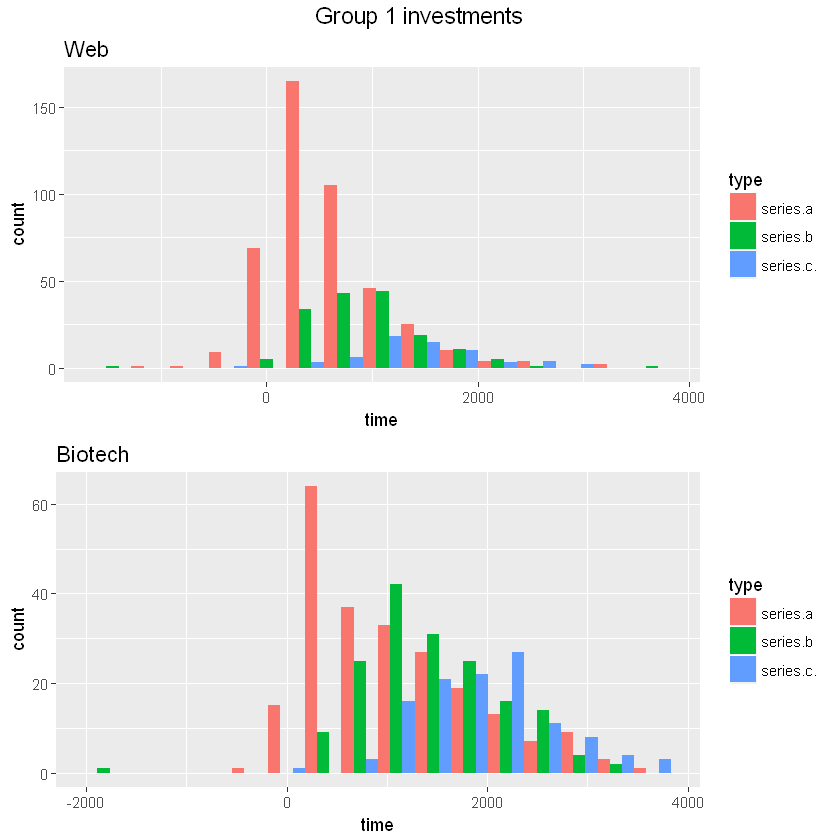

In [275]:
library(gridExtra)
grid.arrange(plot2, plot4,nrow=2, top=textGrob(" Group 1 investments ",gp=gpar(fontsize=14,font=1)))

These plots are very interesting, because we see a clear difference between Web and Biotech in the series.a investments. At the same time, Web startups got twice as many series.a investment compared to Biotech. After that, the quantity of investments is about the same, meaning that a lot of Web startups don't go further the 1st investment round.

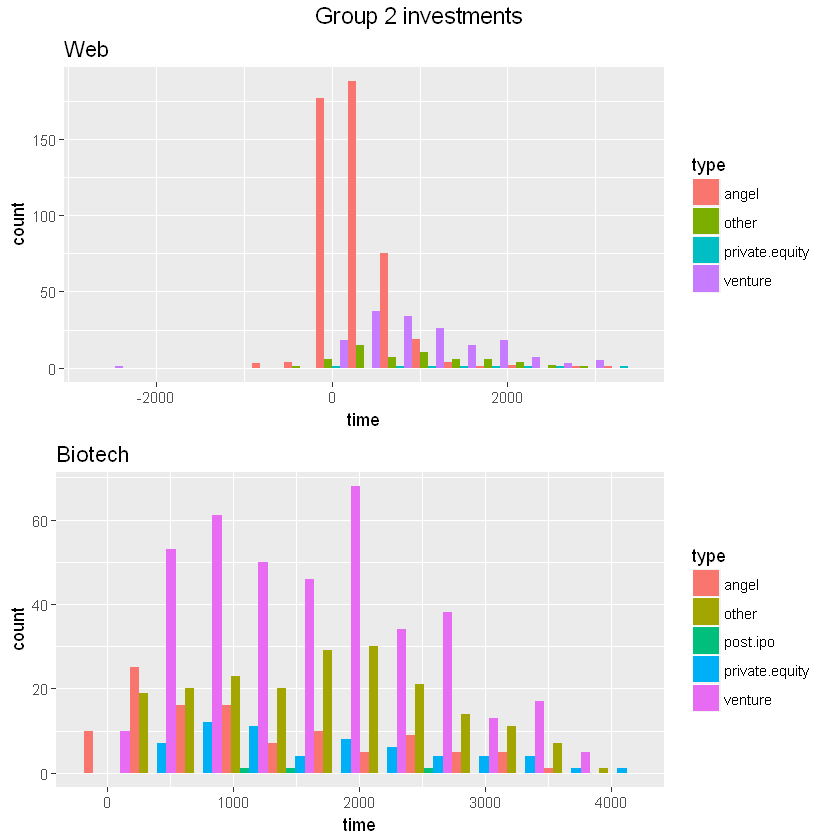

In [276]:
grid.arrange(plot1, plot3,nrow=2,  top=textGrob(" Group 2 investments ",gp=gpar(fontsize=14,font=1)))

Here, we see that web startups receive a lot more funds from business angels than biotech startups, and that biotech receive a bit more venture funds than the web.
We expect to see these variables to have a strong effect on the survival.

Now, let's plot the amount of money invested at each round, against the time when this funding has been made.

Warning message:
"Removed 11 rows containing missing values (geom_point)."Warning message:
"Removed 49 rows containing missing values (geom_point)."Warning message:
"Removed 5 rows containing missing values (geom_point)."Warning message:
"Removed 7 rows containing missing values (geom_point)."

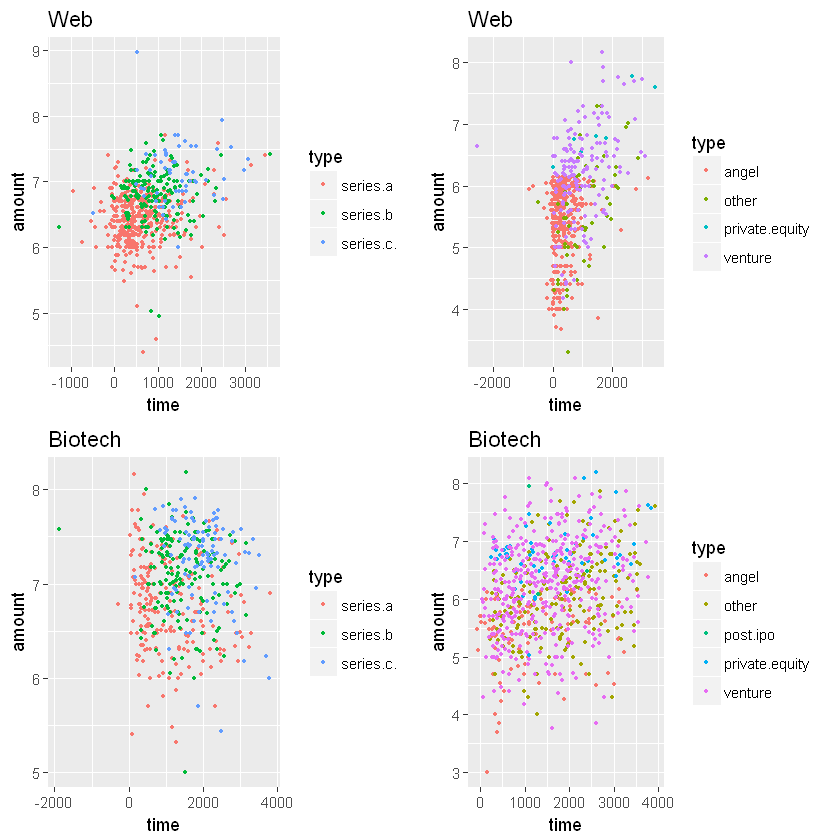

In [277]:
plot1 = ggplot(data=df_to_plot1, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + labs(title='Web')
plot2 = ggplot(data=df_to_plot2, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + labs(title='Web')
plot3 = ggplot(data=df_to_plot3, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + labs(title='Biotech')
plot4 = ggplot(data=df_to_plot4, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + labs(title='Biotech')

grid.arrange(plot2, plot1, plot4, plot3,  nrow=2)

There seems to be some linearity in the web plots. We will test this later.

In [278]:
rm(aa)
rm(bb)
rm(cc)
rm(dd)
rm(ee)
rm(ff)
rm(gg)
rm(hh)
rm(ii)

##  <span style="color:red">III. Machine learning</span>

### <span style="color:red">III.1. Cox models</span>

In [279]:
subset_surv_dataframe <- surv_dataframe[surv_dataframe$category_code %in% c("biotech","web"),]

subset_surv_dataframe <- subset_surv_dataframe[-c(1,4,8,17,26)] #dropping some columns including crowdfunding because it is empty here

#log the money
subset_surv_dataframe$funding_total_usd <- log(subset_surv_dataframe$funding_total_usd+1, base=10)
subset_surv_dataframe$angel <- log(subset_surv_dataframe$angel + 1, base=10)
subset_surv_dataframe$other <- log(subset_surv_dataframe$other + 1, base=10)
subset_surv_dataframe$post.ipo <- log(subset_surv_dataframe$post.ipo + 1, base=10)
subset_surv_dataframe$private.equity <- log(subset_surv_dataframe$private.equity + 1, base=10)
subset_surv_dataframe$series.a <- log(subset_surv_dataframe$series.a + 1, base=10)
subset_surv_dataframe$series.b <- log(subset_surv_dataframe$series.b + 1, base=10)
subset_surv_dataframe$series.c. <- log(subset_surv_dataframe$series.c. + 1, base=10)
subset_surv_dataframe$venture <- log(subset_surv_dataframe$venture + 1, base=10)

summary(subset_surv_dataframe)

 funding_total_usd funding_rounds   target_acquired  target_closed    
 Min.   :0.6021    Min.   : 1.000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.8311    1st Qu.: 1.000   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :0.8698    Median : 1.000   Median :0.0000   Median :0.00000  
 Mean   :0.8655    Mean   : 1.929   Mean   :0.1053   Mean   :0.04154  
 3rd Qu.:0.9040    3rd Qu.: 2.000   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :1.0024    Max.   :14.000   Max.   :1.0000   Max.   :1.00000  
                                                                      
     angel            other           post.ipo        private.equity   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.000000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.000000   1st Qu.:0.00000  
 Median :0.0000   Median :0.0000   Median :0.000000   Median :0.00000  
 Mean   :0.2638   Mean   :0.1237   Mean   :0.001566   Mean   :0.03606  
 3rd Qu.:0.7863   3rd Qu.:0.0000   3rd Qu.:0.000000   3rd Qu.:0.00000  


#### <span style="color:blue">III.1.1. Acquired model</span>

In [280]:
fit.webAcquired = coxph(data=web_surv_df, formula= surv_target_acquired ~ angel + other  + private.equity + series.a + series.b  + series.c. + venture)
fit.bioAcquired = coxph(data=biotech_surv_df, formula= surv_target_acquired ~ angel + other + post.ipo + private.equity + series.a + series.b  + series.c. + venture)

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  3 ; beta may be infinite. "Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  3,4 ; beta may be infinite. "

cox.zph => 
    
    - H0 : The Cox assumption is not met
    - H1 : The model is correctly fitted
    
We are looking for p-values smaller than 0.05

In [281]:
cox.zph(fit.webAcquired)

                   rho    chisq      p
angel          0.05485 4.19e-01 0.5174
other          0.09704 1.21e+00 0.2704
private.equity 0.08056 8.06e-09 0.9999
series.a       0.00375 1.76e-03 0.9665
series.b       0.22844 6.54e+00 0.0105
series.c.      0.02054 5.32e-02 0.8177
venture        0.04764 3.41e-01 0.5594
GLOBAL              NA 1.04e+01 0.1694

In [282]:
cox.zph(fit.bioAcquired)

                   rho    chisq     p
angel          -0.0865 1.76e-01 0.675
other           0.1613 5.13e-01 0.474
post.ipo        0.0552 2.47e-11 1.000
private.equity  0.3710 9.20e-09 1.000
series.a       -0.2407 1.16e+00 0.282
series.b       -0.1456 6.15e-01 0.433
series.c.       0.1220 5.06e-01 0.477
venture        -0.2613 1.56e+00 0.212
GLOBAL              NA 4.29e+00 0.830

Only the series.b. is significant to determine the acquisition of web startups.

#### <span style="color:blue">III.1.2. Closed model</span>

In [283]:
fit.webClosed = coxph(data=web_surv_df, formula= surv_target_closed ~ angel + other  + private.equity + series.a + series.b  + series.c. + venture)
fit.bioClosed = coxph(data=biotech_surv_df, formula= surv_target_closed ~ angel + other + post.ipo + private.equity + series.a + series.b  + series.c. + venture)

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  3 ; beta may be infinite. "Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  1,3,4 ; beta may be infinite. "

In [284]:
cox.zph(fit.webClosed)

                    rho    chisq       p
angel           0.17654 1.81e+00 0.17858
other           0.19407 2.50e+00 0.11408
private.equity  0.00543 2.05e-11 1.00000
series.a        0.22073 2.75e+00 0.09742
series.b        0.31932 5.05e+00 0.02462
series.c.      -0.35879 6.70e+00 0.00965
venture         0.10127 6.76e-01 0.41083
GLOBAL               NA 1.52e+01 0.03379

In [285]:
cox.zph(fit.bioClosed)

                  rho    chisq      p
angel           0.781 2.94e-08 0.9999
other           0.564 3.33e+00 0.0679
post.ipo        0.825 1.96e-09 1.0000
private.equity  0.839 1.20e-08 0.9999
series.a        0.152 2.11e-01 0.6461
series.b       -0.136 2.01e-01 0.6537
series.c.       0.392 2.29e+00 0.1306
venture         0.696 5.48e+00 0.0192
GLOBAL             NA 9.42e+00 0.3081

These are the best fitted models, even with the lack of observations for closed startups. However, the model for biotechnologies is not too good. We can see that series a,b,and c are significant in the closing status for web startups.

#### <span style="color:blue">III.1.3. Both model</span>

In [286]:
fit.webBoth <- coxph(data=web_surv_df, formula= surv_target_all ~ angel + other  + private.equity + series.a + series.b  + series.c. + venture)
fit.bioBoth <- coxph(data=biotech_surv_df, formula= surv_target_all ~ angel + other  + private.equity + series.a + series.b  + series.c. + venture)

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  3 ; beta may be infinite. "Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
"Loglik converged before variable  3 ; beta may be infinite. "

In [287]:
cox.zph(fit.webBoth)

                    rho    chisq       p
angel           0.07062 9.72e-01 0.32425
other           0.08322 1.35e+00 0.24447
private.equity  0.12177 1.91e-08 0.99989
series.a        0.07112 9.07e-01 0.34097
series.b        0.24580 1.04e+01 0.00123
series.c.      -0.00885 1.41e-02 0.90554
venture         0.04521 4.44e-01 0.50497
GLOBAL               NA 1.67e+01 0.01913

In [288]:
cox.zph(fit.bioBoth)

                    rho    chisq     p
angel           0.01189 4.81e-03 0.945
other           0.25892 2.04e+00 0.154
private.equity  0.40797 1.94e-08 1.000
series.a       -0.10964 3.57e-01 0.550
series.b       -0.12376 6.06e-01 0.436
series.c.       0.20524 2.06e+00 0.151
venture        -0.00811 2.12e-03 0.963
GLOBAL               NA 4.93e+00 0.668

The Cox model is never really statistically applicable in any case, and this might be because we are using time-dependant covariates (the fundings). The model could work if we could transform each variable to be understood as time-dependent by the model, but it requires knowledge that we don't have yet.

At this point, the best way to model the surival of a startup could be with a linear regression, over the plots in <span style="color:red">II.3.</span>, where we see the effect of time.

### <span style="color:red">III.2. Linear models</span>

We test the following assumption in the linear regression : 

    - H0: all betas are equal to 0 (no linearity)
    - H1: there exists a linearity in the data points

In [289]:
summary(lm(amount ~ time, data=df_to_plot1))  #web group2
print("-----------------------------------------------------------------------------------")
summary(lm(amount ~ time, data=df_to_plot2))  #web group1
print("-----------------------------------------------------------------------------------")
summary(lm(amount ~ time, data=df_to_plot3))  #biotech group2
print("-----------------------------------------------------------------------------------")
summary(lm(amount ~ time, data=df_to_plot4))  #biotech group1


Call:
lm(formula = amount ~ time, data = df_to_plot1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3266 -0.3934  0.1310  0.4481  2.5696 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.366e+00  3.504e-02   153.1   <2e-16 ***
time        5.073e-04  4.158e-05    12.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6648 on 654 degrees of freedom
  (49 observations deleted due to missingness)
Multiple R-squared:  0.1854,	Adjusted R-squared:  0.1842 
F-statistic: 148.9 on 1 and 654 DF,  p-value: < 2.2e-16


[1] "-----------------------------------------------------------------------------------"



Call:
lm(formula = amount ~ time, data = df_to_plot2)

Residuals:
   Min     1Q Median     3Q    Max 
-2.164 -0.268 -0.002  0.258  2.447 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.413e+00  2.660e-02 241.126  < 2e-16 ***
time        2.242e-04  2.715e-05   8.258 8.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4279 on 654 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.09442,	Adjusted R-squared:  0.09304 
F-statistic: 68.19 on 1 and 654 DF,  p-value: 8.217e-16


[1] "-----------------------------------------------------------------------------------"



Call:
lm(formula = amount ~ time, data = df_to_plot3)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.83561 -0.53026  0.03145  0.56152  2.05829 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.803e+00  5.672e-02 102.299  < 2e-16 ***
time        2.113e-04  3.127e-05   6.759 2.78e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7929 on 755 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.05706,	Adjusted R-squared:  0.05581 
F-statistic: 45.68 on 1 and 755 DF,  p-value: 2.779e-11


[1] "-----------------------------------------------------------------------------------"



Call:
lm(formula = amount ~ time, data = df_to_plot4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.98544 -0.37301  0.05725  0.39816  1.20184 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.977e+00  4.432e-02 157.421   <2e-16 ***
time        5.490e-06  2.719e-05   0.202     0.84    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5046 on 507 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  8.039e-05,	Adjusted R-squared:  -0.001892 
F-statistic: 0.04076 on 1 and 507 DF,  p-value: 0.8401


Except for the group1 investments in biotech, the p-values in the other groups tell that they seem to follow a linear trend.

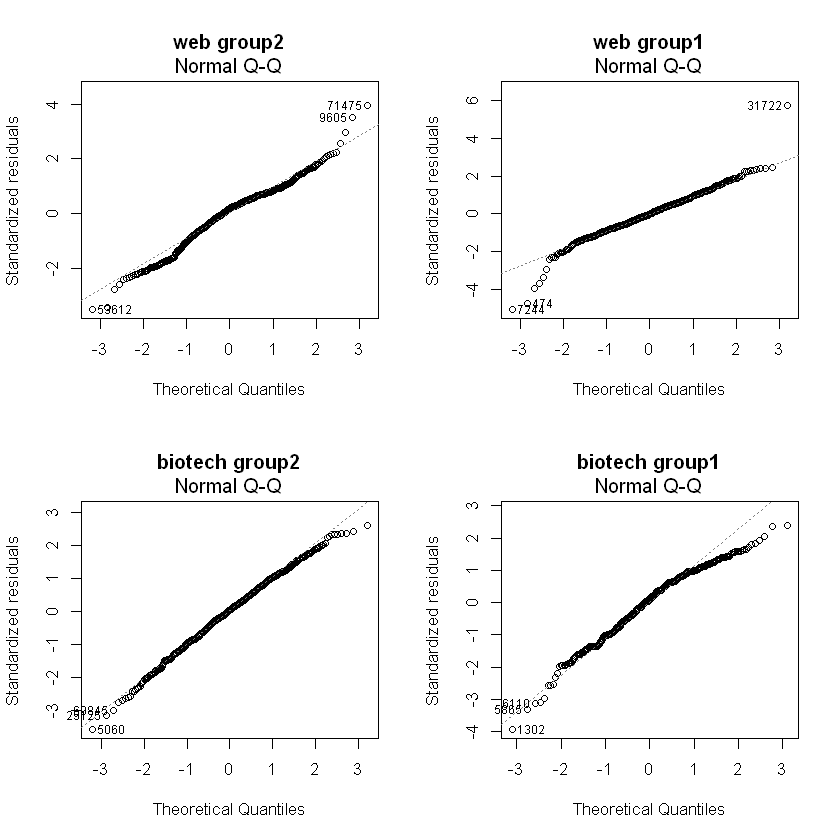

In [290]:
par(mfrow=c(2,2))

plot(lm(amount ~ time, data=df_to_plot1), which=2, main = "web group2")
plot(lm(amount ~ time, data=df_to_plot2), which=2, main = "web group1")
plot(lm(amount ~ time, data=df_to_plot3), which=2, main = "biotech group2")
plot(lm(amount ~ time, data=df_to_plot4), which=2, main = "biotech group1")

The QQ plots are not perfect, but the assumption of normality looks to be almost satisfied.

Warning message:
"Removed 11 rows containing missing values (geom_point)."Warning message:
"Removed 49 rows containing missing values (geom_point)."Warning message:
"Removed 5 rows containing missing values (geom_point)."Warning message:
"Removed 7 rows containing missing values (geom_point)."

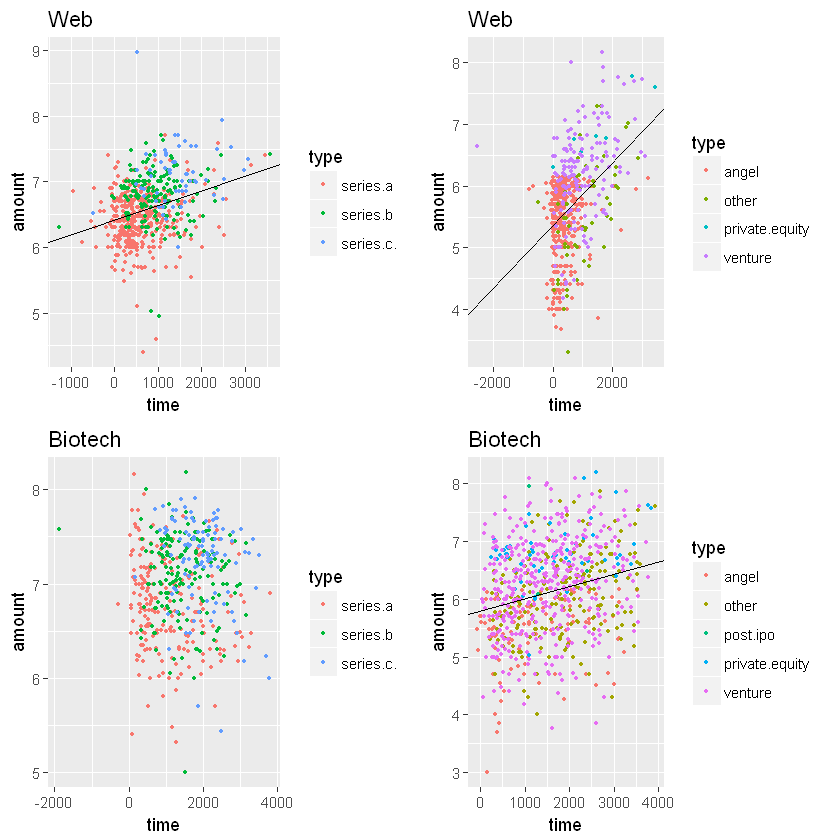

In [291]:
plot1 = ggplot(data=df_to_plot1, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + geom_abline(intercept=5.366e+00, slope=5.073e-04) + labs(title='Web')
plot2 = ggplot(data=df_to_plot2, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + geom_abline(intercept=6.413e+00, slope=2.242e-04) + labs(title='Web')
plot3 = ggplot(data=df_to_plot3, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + geom_abline(intercept=5.803e+00, slope=2.113e-04) + labs(title='Biotech')
plot4 = ggplot(data=df_to_plot4, aes(x=time, y=amount, group=type, col=type)) + geom_point(size=0.8) + labs(title='Biotech')

grid.arrange(plot2, plot1, plot4, plot3,  nrow=2)